In [1]:
import pandas as pd
import json
import os
from pathlib import Path
import seaborn as sns
sns.mpl.rcParams['axes.formatter.useoffset'] = False
sns.set_style('whitegrid')
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize, brentq
%matplotlib inline

root = '../calc/2017-02-13-graphene-flakes'
import sys
sys.path.append(root)
import caf
from caflib.Cellar import Cellar
from caflib.Utils import slugify

ev = 27.2107
kcal = 627.503

def savefig():
    sns.plt.savefig(os.path.expanduser('~/Downloads/fig.pdf'), transparent=True)

In [2]:
cellar = Cellar(f'{root}/.caf')
tree = cellar.get_tree(objects=True)

In [3]:
data = []
for hashid, path in tree.glob('{dimers*,monomers}/*/*/*'):
    fragment, name, xc, basis = path.split('/')
    if 'strip' in name:
        continue
    if 'outputs' not in tree.objects[hashid]:
        continue
    filehash = tree.objects[hashid]['outputs']['run.out']
    with open(cellar.get_file(filehash)) as f:
        try:
            converged = False
            words = next(l for l in f if 'The structure contains' in l).split()
            natoms, nelec = int(words[3]), float(words[9])
            ncarbons = (int(nelec)-natoms)/5
            while True:
                line = next(
                    l for l in f if
                    'Total energy uncorrected      ' in l or
                    'cycle converged' in l or
                    'HOMO-LUMO' in l
                )
                if 'converged' in line:
                    converged = True
                elif 'HOMO' in line:
                    line = (w for w in line.split())
                    next(w for w in line if 'gap' in w)
                    gap = float(next(line))
                else:
                    ene = float(line.split()[5])
        except StopIteration:
            pass
    if not converged:
        ene = np.NaN
    data.append((name, xc, basis, fragment, ene, nelec, ncarbons, gap))
data = pd.DataFrame.from_records(
    data,
    columns='name xc basis fragment ene nelec ncarbons gap'.split()
).set_index('name xc basis fragment'.split(), verify_integrity=True).sort_index()

In [7]:
def get_int_ene(x):
    if len(x) != 3:
        return
    x = x.unstack().iloc[0]
    df = pd.DataFrame({
        'ene': [
            x['ene', 'dimers-AA']-2*x['ene', 'monomers'],
            x['ene', 'dimers-AB']-2*x['ene', 'monomers']
        ],
        'nelec': x['nelec', 'dimers-AA'],
        'ncarbons': x['ncarbons', 'dimers-AA'],
        'gap': [x['gap', 'dimers-AA'], x['gap', 'dimers-AB']]
    }, index=pd.Index(['AA', 'AB'], name='stacking'))
    return df
    
data_int = data.groupby(level='name basis xc'.split()).apply(get_int_ene)
data_int['ene'].swaplevel('stacking', 'xc').sort_index().unstack()

xc                            b3lyp       lda       m06       pbe   pbe+mbd  \
name       basis stacking                                                     
benzene    light AA        0.380496  0.031996  0.063733  0.281020  0.065646   
                 AB        0.187645 -0.111746 -0.076334  0.104379 -0.086447   
           tight AA        0.402750  0.045149  0.106687  0.292701  0.082044   
                 AB        0.205537 -0.100308 -0.044930  0.114724 -0.071781   
coronene   light AA        1.126867 -0.135203 -0.273625  0.822416 -0.296433   
                 AB        0.574150 -0.608122 -0.709053  0.298785 -0.770537   
           tight AA        1.273120 -0.031574 -0.033823  0.918360 -0.185380   
                 AB        0.696121 -0.519174 -0.521362  0.384978 -0.669922   
coronene+1 light AA        2.246050 -0.489770 -0.981103  1.629369 -1.113439   
                 AB        1.169664 -1.468033 -1.833198  0.590844 -2.084146   
           tight AA        2.616716 -0.219213 -0.401464  1.881276 -0.832669   
                 AB        1.480600 -1.236254 -1.375798  0.817829 -1.830220   
coronene+2 light AA        3.736618 -1.032904 -2.057547  2.700519 -2.374860   
                 AB        1.966813 -2.697838 -3.453739  0.973909 -4.021225   
           tight AA        4.432588 -0.518345 -0.993170  3.180546 -1.849527   
                 AB        2.552093 -2.256837 -2.611416  1.407539 -3.546345   
graphene   light AA        0.062432 -0.030638 -0.060943  0.044738 -0.073029   
                 AB        0.035350 -0.059517 -0.081078  0.017013 -0.101596   
           tight AA        0.078959 -0.018059 -0.036818  0.056452 -0.060855   
                 AB        0.050430 -0.047669 -0.060740  0.028763 -0.089538   
naphtalene light AA        0.567741  0.007055  0.011344  0.417197  0.016201   
                 AB        0.280510 -0.225362 -0.216075  0.150765 -0.221661   
           tight AA        0.613590  0.037095  0.096481  0.444375  0.050428   
                 AB        0.319678 -0.198725 -0.150386  0.175456 -0.190149   
pyrene     light AA        0.816630 -0.048963 -0.100664  0.597464 -0.094770   
                 AB        0.406391 -0.379994 -0.412971  0.214951 -0.434403   
           tight AA        0.903968  0.011114  0.049023  0.652797 -0.030701   
                 AB        0.479011 -0.328348 -0.297555  0.264435 -0.376346   

xc                           pbe+ts      scan      tpss  
name       basis stacking                                
benzene    light AA        0.002006  0.097781  0.328256  
                 AB       -0.149180 -0.061035  0.147118  
           tight AA        0.020277  0.120113  0.334895  
                 AB       -0.131890 -0.037217  0.154278  
coronene   light AA       -0.710997 -0.013011  0.956137  
                 AB       -1.189593 -0.527358  0.415200  
           tight AA       -0.586209  0.163553  1.059770  
                 AB       -1.074384 -0.358701  0.519437  
coronene+1 light AA       -2.212313 -0.318754  1.882753  
                 AB       -3.210947 -1.376374  0.799165  
           tight AA       -1.895386  0.122259  2.154334  
                 AB       -2.919931 -0.962205  1.072623  
coronene+2 light AA       -4.496182 -0.819778  3.107184  
                 AB       -6.209505 -2.612617  1.293307  
           tight AA       -3.900637  0.000664  3.623183  
                 AB       -5.663553 -1.848276  1.813536  
graphene   light AA       -0.129027 -0.031666  0.050359  
                 AB       -0.160174 -0.062445  0.020264  
           tight AA       -0.114920 -0.012627  0.062806  
                 AB       -0.146215 -0.044035  0.034021  
naphtalene light AA       -0.112529  0.092991  0.487930  
                 AB       -0.349656 -0.160975  0.214823  
           tight AA       -0.073802  0.147765  0.514335  
                 AB       -0.312985 -0.105426  0.242552  
pyrene     light AA       -0.347956  0.055313  0.696897  
                 AB       -0.683497 -0.307411  0.303538  
     

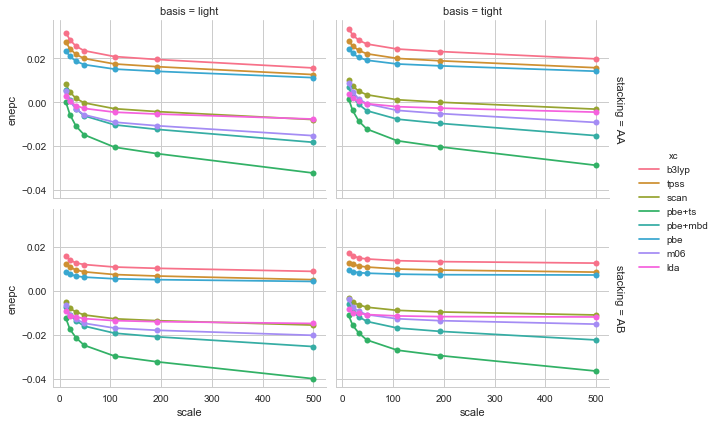

In [9]:
def subtract_lda(x):
    lda = x.xs('lda', level='xc')['ene'].iloc[0]
    return x.assign(rene=lambda y: y['ene']-lda)

def plot(x, y, **kwargs):
    sns.plt.plot(x, y, 'o', markersize=6, **kwargs)
    sns.plt.plot(x, y, '-', **kwargs)

sns.FacetGrid(
    data=data_int.groupby(level='name basis stacking'.split()).apply(subtract_lda)
        .reset_index()
        .assign(renepc=lambda x: x['rene']/x['ncarbons'])
        .assign(enepc=lambda x: x['ene']/x['ncarbons'])
        .assign(scale=lambda x: np.where(x['name'] == 'graphene', 500, x['ncarbons']))
        .sort_values('scale'),
    hue='xc',
    margin_titles=True,
    row='stacking',
    col='basis',
    aspect=1.5,
).map(plot, 'scale', 'enepc').add_legend()

In [9]:
data_int.loc[(slice(None), 'tight', slice(None), 'AB'), 'gap'].unstack(2)

,,xc,b3lyp,lda,m06,pbe,pbe+mbd,pbe+ts,scan,tpss
name,basis,stacking,,,,,,,,
benzene,tight,AB,5.839775,4.379242,6.241184,4.431158,4.431158,4.431158,4.743531,4.580982
coronene,tight,AB,3.437824,2.379002,3.746185,2.406497,2.406497,2.406497,2.570853,2.485422
coronene+1,tight,AB,2.308198,1.488464,2.556607,1.506706,1.506706,1.506706,1.611973,1.557500
coronene+2,tight,AB,1.642198,0.984956,1.848722,0.997426,0.997426,0.997426,1.069743,1.032449
graphene,tight,AB,1.333838,0.854448,1.457603,0.870695,0.870695,0.870695,0.921370,0.895905
naphtalene,tight,AB,4.124538,2.849152,4.497394,2.880629,2.880629,2.880629,3.094881,2.983801
pyrene,tight,AB,3.165837,2.091781,3.502564,2.116205,2.116205,2.116205,2.276685,2.194034


In [4]:
def normalize_names(col):
    if col.name == 'xc':
        return col.str.upper()
    return col

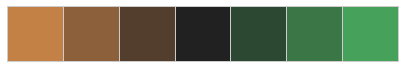

In [5]:
sns.palplot(sns.diverging_palette(40, 133, l=60, n=7, center="dark"))

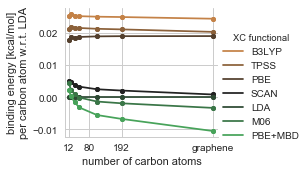

In [10]:
def plot(x, y, **kwargs):
    sns.plt.plot(x, y, 'o', markersize=5, **kwargs)
    sns.plt.plot(x, y, 'o', markersize=5, **kwargs)
    sns.plt.plot(x, y, '-', **kwargs)

    
with sns.diverging_palette(40, 133, l=60, n=7, center="dark"):
    g = sns.FacetGrid(
        data=data_int
            .xs('tight', level='basis')
            .xs('AB', level='stacking')
            .groupby(level='name').apply(subtract_lda)
            .reset_index()
            .assign(renepc=lambda x: x['rene']/x['ncarbons'])
            .assign(enepc=lambda x: x['ene']/x['ncarbons'])
            .assign(scale=lambda x: np.where(x['name'] == 'graphene', 500, x['ncarbons']))
            .sort_values('scale')
            .loc[lambda x: x['xc'] != 'pbe+ts']
            .apply(normalize_names)
            .rename(columns={'xc': 'XC functional'}),
        hue='XC functional',
        hue_order='B3LYP TPSS PBE SCAN LDA M06 PBE+MBD'.split(),
        aspect=1.3,
        size=2.5
    ).map(plot, 'scale', 'renepc').add_legend()
sns.plt.xlim(0, 520)
g.set_xlabels('number of carbon atoms')
g.set_ylabels('binding energy [kcal/mol]\nper carbon atom w.r.t. LDA')
# g.set_([0, 100, 200, '', '', 'graphene'])
xtics = [12, 80, 192, 500]
g.set(xticks=xtics)
g.set_xticklabels(xtics[:-1] + ['graphene'])
savefig()